# [MICRO-452:] Project Report - Groupe 28
**Authors:** Celest Angela Tjong, Adrien Louis Baptiste Dupont, Luca Sidoti Pinto, Didier Henri Neuenschwander
**Supervisors:** Prof. Francesco Mondada
Date: 17 Novembre 2023

[MICRO-452]: **to be changed**

# Table of Contents
* [1. Introduction](#introduction)
* [2. Vision](#vision)
    * [2.1. Subsection 1](#vision-subsection-1)
    * [2.2. Subsection 2](#vision-subsection-2)
* [3. Global Navigation](#global-navigation)
* [4. Filtering](#filtering)
* [5. Local Navigation](#local-navigation)
* [6. Conclusion](#conclusion)


## Introduction
<a id="introduction"></a>

This project, integrated into the MICRO-452 Basics of Mobile Robotics course, aims to combine various essential elements of mobile robotics: vision, global and local navigation, motion control, and filtering.

Here is how the project was implemented. Initially, a webcam captures the image of the environment. The necessary information for operation, such as the robot’s position, the map, static obstacles, and the target’s position, are extracted in real-time using conventional image processing techniques. Subsequently, the A* algorithm is used to determine the optimal path. The robot follows this path, while the Kalman filter estimates the position during movement. Knowledge of the path and the robot’s position allows for control of its movement. If the Thymio detects an obstacle using its horizontal proximity sensors, local navigation takes over to avoid a collision. In addition, the robot can find its way back to the target in case of kidnapping. Finally, the Thymio is designed to reach the target even if the camera’s vision is obstructed.

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
from PIL import Image
import math
import time
from ipywidgets import interactive
%matplotlib inline

## Vision
<a id="vision"></a>
https://docs.opencv.org/4.x/df/d9d/tutorial_py_colorspaces.html

### Vision Subsection 1
<a id="Vision-subsection-1"></a>
**Ask to TA if we have to describe every function used in the notebook?**
1. **Color Space Conversion**:
   -In order to have consistent result for the detection, it is standard to convert     The function begins by converting the input image from the BGR color space (standard in OpenCV) to the HSV color space using `cv2.cvtColor`. HSV (Hue, Saturation, Value) is often more effective for color filtering. Indeed it is particulary usefull for image processing  because it separates color information (hue) from intensity or lighting (value). Thus it allows the recognition to be less dependant of the lighting condition, as it is possible to modify theses parameter. In order to fix the variables of the color used, it is a good practise to calibrate the calibrate the HSV in case of light changes. It has been done with the function...




1. **Color Space Conversion**:
   -In order to have consistent result for the detection, it is standard to convert     The function begins by converting the input image from the BGR color space (standard in OpenCV) to the HSV color space using `cv2.cvtColor`. HSV (Hue, Saturation, Value) is often more effective for color filtering. Indeed it is particulary usefull for image processing  because it separates color information (hue) from intensity or lighting (value). It allows the recognition to be less dependant of the lighting condition, as it is possible to modify theses parameter. 



In [2]:
# Define color thresholds in HSV
# Note: these thresholds may need to be adjusted for your specific image conditions
lower_red_bound = np.array([120, 100, 70])
upper_red_bound = np.array([255, 255, 255])
lower_green_bound = np.array([60, 50, 100])
upper_green_bound = np.array([100, 255, 255])
lower_yellow_bound = np.array([0, 50, 120])
upper_yellow_bound = np.array([40, 105, 255])
lower_black_bound = np.array([0, 0, 0])
upper_black_bound = np.array([255, 255, 130])
lower_blue_bound = np.array([90, 80, 0])
upper_blue_bound = np.array([105, 255, 255])

The first think to do is to preprocess the image for the colour object needed to be located. It is done by first creating a mask. The mask is created by specifying a range of colors (in HSV color space). Pixels within this color range are marked as 1 (or true), while all other pixels are marked as 0 (or false). it is created using `cv2.inRange` which filters out all colors except those within the specified `lower_color_bound` and `upper_color_bound`. This step isolated the specified color. 
Then the function `cv2.bitwise_and`, extract the area corresponding with the range of colour of the image given as input. It is done by comaparing each pixel of the image with the mask (same size of the image, comaparing with a logical &). 
Finally The color-filtered image is converted to grayscale using `cv2.cvtColor` because the subsequent edge detection step (Canny) requires a single-channel image.


In order to detect the different coloured form, it is common to beginby using a canny filter

### Function: `detect_color_circle`

#### Purpose:
The `detect_color_circle` function is designed to detect circles of a specific color in an image. It employs color filtering, Canny edge detection, and the Hough Circle Transform to achieve this.

#### Process:



2. **Color Masking**:
   - A mask is created using `cv2.inRange` which filters out all colors except those within the specified `lower_color_bound` and `upper_color_bound`. This step isolates the regions of the specified color.

3. **Mask Application**:
   - The mask is then applied to the original image using `cv2.bitwise_and`. This step ensures that only the parts of the image with the desired color are retained for further processing.

4. **Grayscale Conversion**:
   - The color-filtered image is converted to grayscale using `cv2.cvtColor` because the subsequent edge detection step (Canny) requires a single-channel image.

5. **Canny Edge Detection**:
   - `cv2.Canny` is applied to detect edges in the image. It works by identifying areas in the image where sharp changes in intensity occur. The function takes two threshold values (here, 100 and 200) that determine the sensitivity of the edge detection. Edges that are found are used as input for the circle detection.

6. **Hough Circle Transform**:
   - `cv2.HoughCircles` is used to detect circles in the image. It operates on the principle of the Hough Transform, which is a feature extraction technique used in image analysis. The function detects circles by finding sets of edge points that form a circular shape.
   - Parameters like `param1` (higher threshold of the two passed to the Canny edge detector), `param2` (threshold for center detection in the Hough Transform), `minRadius`, and `maxRadius` control the sensitivity and size of the circles to be detected.

7. **Output**:
   - If circles are detected, the function returns a list of tuples, each containing the `(x, y)` coordinates of the center of a circle and its radius. If no circles are found, it returns an empty list.


In [3]:
# Define a function to detect circles of a specific color
def detect_color_circle(image, lower_color_bound, upper_color_bound):
    # Convert to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Create a mask for the specified color
    mask = cv2.inRange(hsv, lower_color_bound, upper_color_bound)

    # Apply the mask to the original image
    color_only = cv2.bitwise_and(image, image, mask=mask)

    # Convert to grayscale for circle detection
    gray = cv2.cvtColor(color_only, cv2.COLOR_BGR2GRAY)

    # Apply Canny edge detection to help with circle detection
    edges = cv2.Canny(gray, 100, 200)

    # Use Hough Transform to detect circles
    circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, 1, 20,
                           param1=20, param2=15, minRadius=10, maxRadius=50)
    
    # If circles are detected, return the list of circles with x, y coordinates and radius
    if circles is not None:
        # Convert the (1, N, 3) array to (N, 3)
        circles = np.uint16(np.around(circles[0, :]))          
        return [(circle[0], circle[1], circle[2]) for circle in circles]
    else:
        return []

In [4]:
def create_obstacle_mask(image, contours, kernel_size):
    """
    Create a mask with zeros in the areas inside the dilated contours.

    :param image: Input image.
    :param contours: Contours to dilate and fill in the mask.
    :param kernel_size: Size of the kernel used for dilation.
    :return: Mask with zeros inside the dilated contours and ones elsewhere.
    """
    # Create an empty mask of the same size as the image
    h, w = image.shape[:2]
    mask = np.ones((h, w), dtype=np.uint8)

    # Perform dilation to increase the size of the black regions
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    for contour in contours:
        # Create an individual mask for each contour
        contour_mask = np.zeros((h, w), dtype=np.uint8)
        cv2.fillPoly(contour_mask, [contour], 255)
        contour_mask = cv2.dilate(contour_mask, kernel, iterations=1)
        
        # Combine the individual mask with the global mask
        mask = cv2.bitwise_and(mask, cv2.bitwise_not(contour_mask))

        #also add the contours
        # Let's create a border around the image
        border_size = 50
        border_color = [0, 0, 0]  # Black border
        # Use cv2.copyMakeBorder to add a border around the image
        mask_with_border = cv2.copyMakeBorder(mask, border_size, border_size, border_size, border_size,
                                           cv2.BORDER_CONSTANT, value=border_color)
    
    return mask_with_border


# Now you have a mask with zeros in the obstacle areas and ones elsewhere
# You can return this mask from your function or process it further as needed

In [5]:
def detect_obstacle_contours(image, area_threshold, kernel_size):
    """
    Detects and dilates obstacle contours in the given image.
    :param image: Input image.
    :param area_threshold: Area threshold for filtering contours.
    :param kernel_size: Size of the kernel used for dilation.
    :return: Image with obstacle contours drawn.
    """
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask_black = cv2.inRange(hsv, lower_black_bound, upper_black_bound)
    contours, _ = cv2.findContours(mask_black, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > area_threshold]
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    mask_dilated = cv2.dilate(mask_black, kernel, iterations=1)
    dilated_contours, _ = cv2.findContours(mask_dilated, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    filtered_dilated_contours = [cnt for cnt in dilated_contours if cv2.contourArea(cnt) > area_threshold+10000]
    contour_image = image.copy()
    cv2.drawContours(contour_image, filtered_contours, -1, (0, 255, 0), 2)
    cv2.drawContours(contour_image, filtered_dilated_contours, -1, (0, 0, 255), 2)
    return contour_image, filtered_contours, filtered_dilated_contours

In [6]:
def create_obstacle_matrix(image, dilated_contours):
    height, width = image.shape[:2]
    obstacle_matrix = np.ones((height, width), dtype=np.uint8)

    for contour in dilated_contours:
        # Remplir chaque contour dilaté avec 0 (obstacle)
        cv2.fillPoly(obstacle_matrix, [contour], 0)

    return obstacle_matrix

In [7]:
def crop_roi_from_circles(image, circles):
    if circles is not None and len(circles) >= 4:
        # Assurez-vous que les points sont dans le format correct
        points = np.array([circle[:2] for circle in circles], dtype=np.float32)

        # Calcul de la boîte englobante
        rect = cv2.boundingRect(points)

        # Recadrage de l'image
        x, y, w, h = rect
        cropped_image = image[y:y+h, x:x+w]
        return cropped_image,(x, y, w, h)
    else:
        print("Nombre insuffisant de cercles détectés ou format incorrect.")
        return image,None 

In [8]:
def find_rectangle_center(image, lower_colour_bound, upper_colour_bound, area_threshold=1000):
    # Convertir l'image en espace de couleur HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Créer un masque pour la couleur 
    mask = cv2.inRange(hsv, lower_colour_bound, upper_colour_bound)

    # Trouver les contours dans le masque
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Identifier le contour qui correspond au rectangle 
    for contour in contours:
        if cv2.contourArea(contour) > area_threshold:
            # Calculer la boîte englobante pour le contour
            x, y, w, h = cv2.boundingRect(contour)

            # Effacer le rectangle en le dessinant en blanc
            cv2.rectangle(image, (x, y), (x + w, y + h), (255, 255, 255), -1)

            # Calculer le centre du rectangle
            center = (x + w // 2, y + h // 2)
            return center

    return None

In each frame, there are multiple elements that need to be displayed. The first category includes static elements such as the contours of obstacles and the goal point. Since these do not change over time, it is computationally more efficient to identify and locate them in the first frame, and then display them consistently in subsequent frames.

On the other hand, elements related to the robot's localization must be determined in each frame. To gather information about its orientation and location, three circles are placed on the top of the robot. A green circle is located at the middle back, and two red circles are positioned on each side, with their centers aligned with the robot's ceeris. This arrangement facilitates the extraction of necessary information. By connecting the centers of the two red circles and creating a midpoint, a vector c thenan be formed by connecting this midpoint to the center of the green circ.It might also be feasible to use only two markers (circles), one at the back and one at the front, distinguished by their color. However, the marker at the front would hide the press button.le

In [9]:
def robot_info(frame):
    global camera_on
    red_circles = detect_color_circle(frame, lower_red_bound, upper_red_bound)
    green_circles = detect_color_circle(frame, lower_green_bound, upper_green_bound)
    
    if red_circles and green_circles and len(red_circles) >= 2:
        # Calculate robot's position and orientation vector
        # Calculate the midpoint between the centers of the red circles
        midpoint = ((red_circles[0][0] + red_circles[1][0]) // 2,
        (red_circles[0][1] + red_circles[1][1]) // 2)
        # Calculate the directional vector
        direction = np.array([midpoint[0] - green_circles[0][0], midpoint[1] - green_circles[0][1]])

        # Normalize and extend the vector
        length = 30  # Additional length
        direction = direction / np.linalg.norm(direction) * length

        # Calculate the new endpoint
        new_endpoint = (int(green_circles[0][0] + direction[0]), int(green_circles[0][1] + direction[1]))

        # Draw the extended arrow
        cv2.arrowedLine(frame, new_endpoint, green_circles[0][:2], (0, 0, 0), 3)

        # Calculate the angle of orientation with respect to the x-axis
        dx =   midpoint[0] - green_circles[0][0]
        dy =   midpoint[1] - green_circles[0][1]
        angle = math.atan2(dy, dx)
        angle_degrees = math.degrees(angle)
        if(angle_degrees>= 0):
            angle_degrees =180 - angle_degrees
        elif (angle_degrees < 0):
            angle_degrees = -(180 + angle_degrees)
        robot_vector = (midpoint[0], midpoint[1], np.radians(angle_degrees)) #information of the robot
        #print("ANGLE ",robot_vector[2])
        # Optionally, display the angle
        cv2.putText(frame, f'Angle: {angle_degrees:.2f} degrees', (10, 30), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

        cv2.putText(frame, f'Midpoint: ({midpoint[0]}, {midpoint[1]})', (10, 70),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

        cv2.circle(frame, midpoint,10, (255, 0, 0), -1)
       # cv2.circle(frame, (x, y), r, (0, 255, 255), 3)
        camera_on = True
        return midpoint[0], midpoint[1], angle_degrees#information of the robot

    else:
        camera_on = False
        print("PASSAGE A FALSE")
        return None,None,None

In [10]:
def preprocess_image(video_capture, lower_blue_bound, upper_blue_bound):
    ret, initial_frame = video_capture.read()
    if ret:
        #initial_frame, cropping_coords = crop_largest_white_area(initial_frame, 200000)
        blue_circles = detect_color_circle(initial_frame, lower_blue_bound, upper_blue_bound)
        initial_frame ,cropping_coords= crop_roi_from_circles(initial_frame, blue_circles)
        goal_center = find_rectangle_center(initial_frame, lower_blue_bound, upper_blue_bound,2000)
        if goal_center:
            # Store the coordinates of the detected yellow circle
            yellow_circle_coords = goal_center  # center est déjà un tuple (x, y)
            radius = 10  # Rayon du cercle, vous pouvez ajuster cette valeur
            color = (0, 255, 255)  # Couleur jaune en BGR
            cv2.circle(initial_frame, yellow_circle_coords, radius, color, 3)
        robot_vector = robot_info(initial_frame)
        if robot_vector[0] and robot_vector[1]:
            cv2.circle(initial_frame, (robot_vector[0], robot_vector[1]),80, (255, 255, 255), -1)    
        contour_image = detect_obstacle_contours(initial_frame, 2000, 80)
        global_obstacle = create_obstacle_matrix(initial_frame,contour_image[2])
        # Dessiner le cercle
        initial_frame = np.flipud(initial_frame)
        plt.imshow(cv2.cvtColor(contour_image[0], cv2.COLOR_BGR2RGB))
        plt.title('Initial Contours')
        plt.axis('off')
        plt.show()
        return initial_frame, cropping_coords, contour_image, global_obstacle,goal_center, robot_vector
    else:
        return None, None, None, None, None, None

In [11]:
def process_image(frame, cropping_coords, contour_image, update_rate):
    if cropping_coords is not None:
        x, y, w, h = cropping_coords
        frame = frame[y:y+h, x:x+w]
    # Detect red and green circles
    robot_vector = robot_info(frame)
    if  robot_vector is not None:
        cv2.drawContours(frame, contour_image[1], -1, (0, 255, 0), 2)
        cv2.drawContours(frame, contour_image[2], -1, (0, 0, 255), 2)

        # Display the resulting frame
        cv2.imshow('Robot Detection', frame)
    return robot_vector

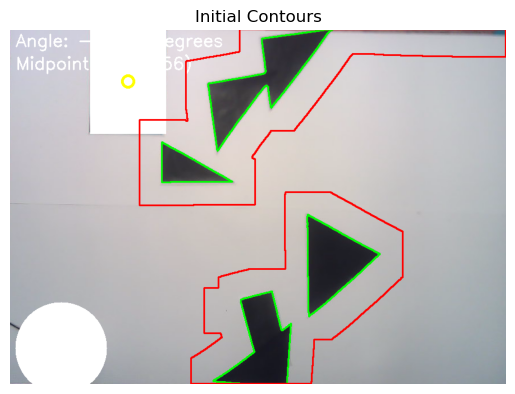

KeyboardInterrupt: 

In [12]:
video_capture = cv2.VideoCapture(1, cv2.CAP_DSHOW)

video_capture.set(cv2.CAP_PROP_FRAME_WIDTH, 1080)
video_capture.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
window_name = 'Robot Detection'
cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)

# Resize the window (width, height)
cv2.resizeWindow(window_name, 540, 360)  

# Initial detection of obstacles and goal
initial_frame, cropping_coords, contour_image, global_obstacle,goal_center, robot_pose = preprocess_image(video_capture, lower_blue_bound, upper_blue_bound)
# Robot update frequency (10 Hz)
update_rate = 0.01  # 10 times per second
if initial_frame is not None:
    try:
        while True:
            start_time = time.time()
            ret, frame = video_capture.read()
            if not ret:
                break
            robot_pose = process_image(frame, cropping_coords, contour_image, update_rate)

            # Pause to maintain the update frequency
            time_to_wait = max(int((start_time + update_rate - time.time()) * 1000), 1)
            if cv2.waitKey(time_to_wait) & 0xFF == ord('q'):
                break

    except Exception as e:
        print(f"An error occurred: {e}")

    finally:
        # Release the capture when everything is finished
        video_capture.release()
        cv2.destroyAllWindows()

In [13]:
def x_robot_projection_to_ground(x_pos_robot):
    return round(0.96*x_pos_robot+16.67)
    
def y_robot_projection_to_ground(y_pos_robot):
    return round(0.95*y_pos_robot+14.29)

In [14]:
print(goal_center)
print(robot_pose)
robot_vector = np.zeros(3)
robot_vector[0] = int(x_robot_projection_to_ground(robot_pose[0]))
robot_vector[1] = int(y_robot_projection_to_ground(robot_pose[1]))
robot_vector[2] = np.radians(robot_pose[2])
print(robot_vector)

(206, 91)
(89, 557, -38.418055344821994)
[102.         543.          -0.67052156]


## Global Navigation
<a id="global-navigation"></a>

---
### Path Planning


The path search is transformed into a graph searchA problem encountered is the computational time needed for a grid the size of the image. To reduce this duration a size reduction coefficient is used to downsize the original grid. The value of this coefficient is chosen to have the best trade-off between computational time and precision.

| `reduction_coeff` | Computation time |
|----------|----------|
| 10 | 9.599 |
| 15 | 2.298 |
| 20 | 0.513 |
| 25 | 0.193 |
| 30 | 0.099 |

The solution with the best trade-off is a reduction factor of 20, allowing an average computational time of XXXXX while keeping acceptable precision.

In [15]:
global_obstacle = np.logical_not( global_obstacle )
max_val_x_init = global_obstacle.shape[0]
max_val_y_init = global_obstacle.shape[1]

reduction_coeff = 25 # tune for speed
max_val_x = int(max_val_x_init / reduction_coeff)
max_val_y = int(max_val_y_init / reduction_coeff)

occupancy_grid = np.zeros((max_val_x, max_val_y), dtype=int)
for i in range (max_val_x):
    for j in range (max_val_y):
        sum_pixels = 0
        for k in range (reduction_coeff): # dans le doute on augmente la distance de sécurité avec obstacle
            
            indice_x = int(i * reduction_coeff - reduction_coeff/2 + k)
            if (indice_x < 0):
                indice_x = 0
            elif (indice_x > (max_val_x_init - 1)):
                indice_x = max_val_x_init -1
            
        
            indice_y = int(j * reduction_coeff - reduction_coeff/2 + k)
            if (indice_y < 0):
                
                indice_y = 0
            elif (indice_y > (max_val_y_init - 1)):
                indice_y = max_val_y_init -1
            
            #print("indice x : ", indice_x, "indice y : ", indice_y)
            sum_pixels = sum_pixels + global_obstacle[indice_x][indice_y]
            

            
        if sum_pixels == 0:
            occupancy_grid[i][j] = 0
        else:
            occupancy_grid[i][j] = 1

In [16]:
def create_empty_plot(max_val):
    """
    Helper function to create a figure of the desired dimensions & grid
    
    :param max_val: dimension of the map along the x and y dimensions
    :return: the fig and ax objects.
    """
    fig, ax = plt.subplots(figsize=(7,7))
    
    major_ticks = np.arange(0, max_val+1, 5)
    minor_ticks = np.arange(0, max_val+1, 1)
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(major_ticks)
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)
    #ax.set_ylim([-1,max_val_x])
    ax.set_ylim([max_val_x,-1])
    ax.set_xlim([-1,max_val_y])
    ax.grid(True)
    
    return fig, ax

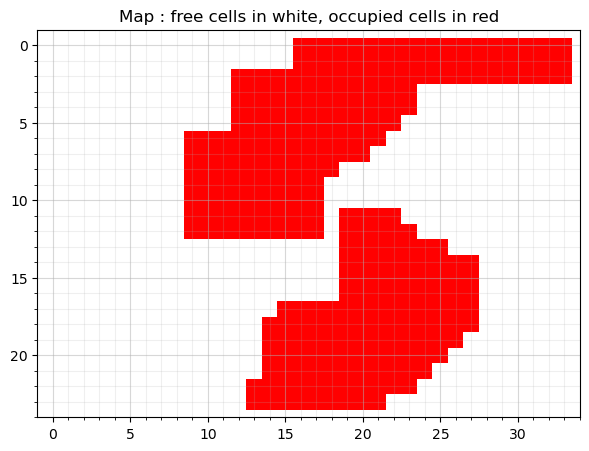

In [17]:
# Printing the grid

fig, ax = create_empty_plot(max_val_y)

cmap = colors.ListedColormap(['white', 'red']) # Select the colors with which to display obstacles and free cells

#occupancy_grid = np.logical_not(occupancy_grid)

# Displaying the map
ax.imshow(occupancy_grid, cmap=cmap)
plt.title("Map : free cells in white, occupied cells in red");

### A* implementation

The path planning for the Thymio is made using a hybrid A* algorithm. This ensures an optimised search by using the distance to goal to choose the nodes to explore. The formula used is the following : 

$$ f(n) = g(n) + h(n) $$

Here f(n) is the function we try to optimise, with g(n) being the motion cost and h(n) the heuristic function. The motion cost has here been tailored to the Thymio's mechanism, as it takes into account on one side the cost of forward motion with `deltacost` and on the other side the rotational cost with `rotational_cost`. Adding the rotational cost is key to avoid repetitive direction changes.

In [18]:
def _get_movements_8n():
    """
    Get all possible 8-connectivity movements. Equivalent to get_movements_in_radius(1)
    (up, down, left, right and the 4 diagonals).
    :return: list of movements with cost [(dx, dy, movement_cost)]
    """
    s2 = math.sqrt(2)
    return [(1, 0, 1.0),
            (0, 1, 1.0),
            (-1, 0, 1.0),
            (0, -1, 1.0),
            (1, 1, s2),
            (-1, 1, s2),
            (-1, -1, s2),
            (1, -1, s2)]

In [19]:

def reconstruct_path(cameFrom, current):
    """
    Recurrently reconstructs the path from start node to the current node
    :param cameFrom: map (dictionary) containing for each node n the node immediately 
                     preceding it on the cheapest path from start to n 
                     currently known.
    :param current: current node (x, y)
    :return: list of nodes from start to current node
    """
    total_path = [current]
    while current in cameFrom.keys():
        # Add where the current node came from to the start of the list
        total_path.insert(0, cameFrom[current]) 
        current=cameFrom[current]
    return total_path

def A_Star(start, goal, h, coords, occupancy_grid, movement_type="4N", max_val_x=max_val_x, max_val_y=max_val_y):
    """
    A* for 2D occupancy grid. Finds a path from start to goal.
    h is the heuristic function. h(n) estimates the cost to reach goal from node n.
    :param start: start node (x, y)
    :param goal_m: goal node (x, y)
    :param occupancy_grid: the grid map
    :param movement: select between 4-connectivity ('4N') and 8-connectivity ('8N', default)
    :return: a tuple that contains: (the resulting path in meters, the resulting path in data array indices)
    """
    
    # -----------------------------------------
    # DO NOT EDIT THIS PORTION OF CODE
    # -----------------------------------------
    
    # Check if the start and goal are within the boundaries of the map
    for point in [start, goal]:
        for coord in point:
            assert coord>=0 and coord<max_val_y, "start or end goal not contained in the map"
    
    # check if start and goal nodes correspond to free spaces
    if occupancy_grid[start[0], start[1]]:
        raise Exception('Start node is not traversable')

    if occupancy_grid[goal[0], goal[1]]:
        raise Exception('Goal node is not traversable')
    
    # get the possible movements corresponding to the selected connectivity
    if movement_type == '4N':
        movements = _get_movements_4n()
    elif movement_type == '8N':
        movements = _get_movements_8n()
    else:
        raise ValueError('Unknown movement')
    
    # --------------------------------------------------------------------------------------------
    # A* Algorithm implementation - feel free to change the structure / use another pseudo-code
    # --------------------------------------------------------------------------------------------
    
    # The set of visited nodes that need to be (re-)expanded, i.e. for which the neighbors need to be explored
    # Initially, only the start node is known.
    openSet = [start]
    
    # The set of visited nodes that no longer need to be expanded.
    closedSet = []

    # For node n, cameFrom[n] is the node immediately preceding it on the cheapest path from start to n currently known.
    cameFrom = dict()

    # For node n, gScore[n] is the cost of the cheapest path from start to n currently known.
    gScore = dict(zip(coords, [np.inf for x in range(len(coords))]))
    gScore[start] = 0

    # For node n, fScore[n] := gScore[n] + h(n). map with default value of Infinity
    fScore = dict(zip(coords, [np.inf for x in range(len(coords))]))
    fScore[start] = h[start]
    
    current = ([0,0])

    # while there are still elements to investigate
    while openSet != []:
        
        previous = current
        
        
        #the node in openSet having the lowest fScore[] value
        fScore_openSet = {key:val for (key,val) in fScore.items() if key in openSet}
        current = min(fScore_openSet, key=fScore_openSet.get)
        del fScore_openSet
        
        #If the goal is reached, reconstruct and return the obtained path
        if current == goal:
            return reconstruct_path(cameFrom, current), closedSet

        openSet.remove(current)
        closedSet.append(current)
        
        #for each neighbor of current:
        for dx, dy, deltacost in movements:
            
            neighbor = (current[0]+dx, current[1]+dy)
            
            # if the node is not in the map, skip
            if (neighbor[0] >= occupancy_grid.shape[0]) or (neighbor[1] >= occupancy_grid.shape[1]) or (neighbor[0] < 0) or (neighbor[1] < 0):
                continue
            
            # if the node is occupied or has already been visited, skip
            if (occupancy_grid[neighbor[0], neighbor[1]]) or (neighbor in closedSet): 
                continue
                
            ROTATION_COST = 1
            
            if(not (current == start)):
                #print(cameFrom)
                vector_prev = ([current[0] - (cameFrom[current])[0], current[1] - (cameFrom[current])[1]]) 
                vector_next = ([neighbor[0] - current[0], neighbor[1] - current[1]]) 
                angle = np.arccos(np.dot(vector_prev, vector_next) / (np.linalg.norm(vector_prev) * np.linalg.norm(vector_next)))
                rotation_cost = angle * ROTATION_COST
            else:
                rotation_cost = 0
                
            # d(current,neighbor) is the weight of the edge from current to neighbor
            # tentative_gScore is the distance from start to the neighbor through current
            tentative_gScore = gScore[current] + deltacost + rotation_cost
            
            if neighbor not in openSet:
                openSet.append(neighbor)
                
            if tentative_gScore < gScore[neighbor]:
                # This path to neighbor is better than any previous one. Record it!
                cameFrom[neighbor] = current
                gScore[neighbor] = tentative_gScore
                fScore[neighbor] = gScore[neighbor] + h[neighbor]

    # Open set is empty but goal was never reached
    print("No path found to goal")
    return [], closedSet


(21, 4)
(3, 8)
 Time for  25  :  0.13393735885620117
[[525 500 475 450 425 400 375 350 325 300 275 250 225 200 175 150 125 100
   75]
 [100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 125 150 175
  200]]


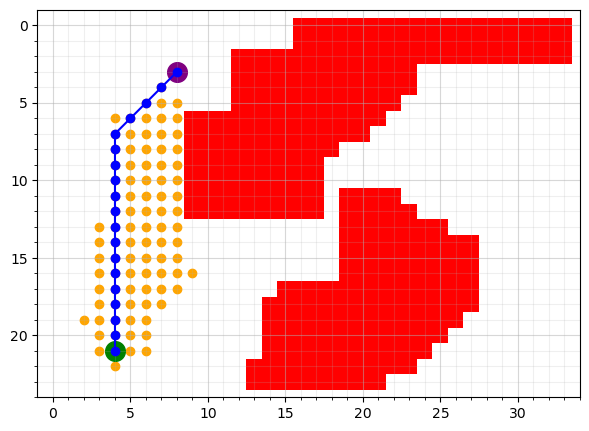

In [20]:
# Define the start and end goal
start = (int(robot_vector[1]/reduction_coeff),int(robot_vector[0]/reduction_coeff))
print(start)
#goal = (int(630 /reduction_coeff),int(900 /reduction_coeff))
goal = (int(goal_center[1]/reduction_coeff),int(goal_center[0]/reduction_coeff))
print(goal)
# -----------------------------------------
# DO NOT EDIT THIS PORTION OF CODE - 
# EXECUTION AND PLOTTING OF THE ALGORITHM
# -----------------------------------------
    
    
# List of all coordinates in the grid
w,z = np.mgrid[0:max_val_x:1, 0:max_val_y:1]
pos = np.empty(w.shape + (2,))
pos[:, :, 0] = w; pos[:, :, 1] = z
pos = np.reshape(pos, (w.shape[0]*w.shape[1], 2))
coords = list([(int(w[0]), int(w[1])) for w in pos])

# Define the heuristic, here = distance to goal ignoring obstacles
h = np.linalg.norm(pos - goal, axis=-1)
h = dict(zip(coords, h))

# Run the A* algorithm
start_time = time.time()

path, visitedNodes = A_Star(start, goal, h, coords, occupancy_grid, movement_type="8N")

end_time = time.time()
elapsed_time = end_time - start_time
print(" Time for ", reduction_coeff, " : ", elapsed_time)

path = np.array(path).reshape(-1, 2).transpose()
visitedNodes = np.array(visitedNodes).reshape(-1, 2).transpose()

path_final = path * reduction_coeff

# Displaying the map
fig_astar, ax_astar = create_empty_plot(max_val_y)
ax_astar.imshow(occupancy_grid, cmap=cmap)
print(path_final)
# Plot the best path found and the list of visited nodes
ax_astar.scatter(visitedNodes[1], visitedNodes[0], marker="o", color = 'orange');
ax_astar.plot(path[1], path[0], marker="o", color = 'blue');
ax_astar.scatter(start[1], start[0], marker="o", color = 'green', s=200);
ax_astar.scatter(goal[1], goal[0], marker="o", color = 'purple', s=200);

- blanc : libre
- rouge : obstacle
- orange : case explorée
- bleu : chemin le plus court
- vert : départ
- violet : arrivée

In [21]:
#print(path_final)
path_final[[0,1]] = path_final[[1,0]] 
#path_final[0][0] = robot_vector[1]
#print(path_final)
#print(robot_vector)
path_final[0][0] = robot_vector[0]
path_final[1][0] = robot_vector[1]
#print(path_final)
#print(goal_center)
path_final[0][-1] = goal_center[0]
path_final[1][-1] = goal_center[1]
print(path_final)
print(robot_vector)

[[102 100 100 100 100 100 100 100 100 100 100 100 100 100 100 125 150 175
  206]
 [543 500 475 450 425 400 375 350 325 300 275 250 225 200 175 150 125 100
   91]]
[102.         543.          -0.67052156]


In [22]:
print(goal_center)

(206, 91)


In [23]:
'''
delta_start_x = robot_vector[0] - path_final[0][0]
delta_start_y = robot_vector[1] - path_final[1][0]
print(delta_start_x)

for i in range(path_final.shape[1] - 1):
    path_final[0][i] += delta_start_x
    path_final[1][i] += delta_start_y

path_final[0][-1] = goal_center[0]
path_final[1][-1] = goal_center[1]
print(path_final)
print(robot_vector)
'''

'\ndelta_start_x = robot_vector[0] - path_final[0][0]\ndelta_start_y = robot_vector[1] - path_final[1][0]\nprint(delta_start_x)\n\nfor i in range(path_final.shape[1] - 1):\n    path_final[0][i] += delta_start_x\n    path_final[1][i] += delta_start_y\n\npath_final[0][-1] = goal_center[0]\npath_final[1][-1] = goal_center[1]\nprint(path_final)\nprint(robot_vector)\n'

Maintenant que nous avons calculé le chemin le plus court, nous appelons des fonctions pour diriger le robot dans la bonne direction. Les données qui sortent de ce fichier sont dans la matrice path_final qui regroupe les coordonées des étapes recalculées à la bonne échelle.

# Main
<a id="main"></a>

## Import

In [24]:
import math
import time
import asyncio
import numpy as np
from tdmclient import aw, ClientAsync

## Basic functions

### Kalman filter

The localization of the Thymio robot is performed using a Kalman filter. This filtering method is well suited to estimating the position and orientation of a mobile robot from noisy or incomplete measurements. The design of the filter in this project is based on using the position ($x, y$) and orientation ($\theta$) provided by the camera as measurements. In addition, the speed of the robot, provided by the wheel speed sensors ($v_r, v_l$), is used as a prediction. In short, the Kalman filter merges a prediction of the system's future state with a measurement of that state to estimate position probabilistically.

## State-space model

### Prediction

To estimate the robot's future position, a state-space model needs to be developed: 

$$\hat{s}_{a\_priori}^{t+1} = A \cdot \hat{s}_{a\_posteriori}^{t} + B \cdot u^{t} + q^t$$

The prediction of the future state is referred to as $\hat{s}_{a\_priori}^{t+1}$, i.e. the a priori estimate at time t+1. Since the state of the system is defined by its position ($x, y$) and orientation ($\theta$), this gives: 

$$\hat{s}_{a\_priori}^{t+1} = \begin{pmatrix}
\hat{x}_{a\_priori}^{t+1} \\\\
\hat{y}_{a\_priori}^{t+1} \\\\
\hat{\theta}_{a\_priori}^{t+1}
\end{pmatrix}$$

The current state corresponds to the term $\hat{s}_{a\_posteriori}^{t}$, which is the a posteriori estimate at time t. In the same way as above, this gives:

$$\hat{s}_{a\_posteriori}^{t} = \begin{pmatrix}
\hat{x}_{a\_posteriori}^{t} \\\\
\hat{y}_{a\_posteriori}^{t} \\\\
\hat{\theta}_{a\_posteriori}^{t}
\end{pmatrix}$$

The system input at time t is represented by the vector $u^{t}$. This is made up of two terms: translational speed ($v$) and rotational speed ($\omega$). 

$$u^t = \begin{pmatrix}
v \\\\
\omega
\end{pmatrix} $$

These are defined on the basis of the speeds measured by the wheel speed sensors, i.e. the right ($v_r$) and left ($v_l$) speeds, and the spacing between the two wheels ($e$).

$$ v = \cfrac{v_r + v_l}{2} \qquad\qquad \omega = \cfrac{v_r-v_l}{e} $$ 

Matrix A characterizes the evolution of the system state, while matrix B describes the impact of the input on the future state. An odometry-based approach allows us to determine these two matrices by considering a very short time interval ($\delta t$). During this time interval, the robot rotates by $\delta \theta = \omega \cdot \delta t$. Knowing this, and referring to the diagram below, the following system of equations can be established: 

$$\begin{equation}
\begin{cases}
\hat{x}_{a\_priori}^{t+1} = \hat{x}_{a\_posteriori}^{t} + v \cdot \cos\left(\hat{\theta}_{a\_posteriori}^{t} + \delta \theta^t \right) \cdot \delta t \\
\hat{y}_{a\_priori}^{t+1} = \hat{y}_{a\_posteriori}^{t} + v \cdot \sin\left(\hat{\theta}_{a\_posteriori}^{t} + \delta \theta^t \right) \cdot \delta t \\
\hat{\theta}_{a\_priori}^{t+1} = \hat{\theta}_{a\_posteriori}^{t} + \omega \cdot \delta t
\end{cases}
\end{equation}$$

![state-space_model](Images/schematics.png)

The matrix form of this system therefore becomes:

$$\begin{equation}
A = \begin{bmatrix} 
1 & 0 & 0\\ 
0 & 1 & 0 \\ 
0 & 0 & 1
\end{bmatrix}
\qquad\qquad
B = \begin{bmatrix} 
\cos\left(\hat{\theta}_{a\_posteriori}^{t} + \delta \theta^t \right) \cdot \delta t & 0\\
\sin\left(\hat{\theta}_{a\_posteriori}^{t} + \delta \theta^t \right) \cdot \delta t & 0 \\
0 & \delta t 
\end{bmatrix}
\end{equation}$$

The final term $q^t$ of this state-space model represents the stochastic perturbation of the state with covariance matrix Q defined as follows:

$$
Q = \begin{bmatrix} 
q_1 & 0 & 0\\ 
0 & q_2 & 0 \\ 
0 & 0 & q_3
\end{bmatrix}
$$

These diagonal coefficients can be evaluated using an approach similar to that used in Exercise 8 of the MICRO-452 course.  

### Measurement

Having explored the prediction phase of the state-space model, attention now turns to the second essential part: updating the measurements. This stage aims to refine the predictions by integrating real information captured by the camera. The formula governing this step is :

$$ m^{t+1} = C \cdot s^{t+1} + r^{t+1}$$ 

Measurements taken at time t+1 are represented here by the term $m_{t+1}$. The data collected by the camera are therefore:

$$m^{t+1} = \begin{pmatrix}
x_{captured}^{t+1} \\\\
y_{captured}^{t+1} \\\\
\theta_{captured}^{t+1}
\end{pmatrix}$$

The robot's position ($x, y$) and orientation ($\theta$) measured by the camera are used directly as system outputs, without any transformation. The matrix C linking the measurements to the state is therefore defined as follows:

$$C = \begin{bmatrix} 
1 & 0 & 0\\ 
0 & 1 & 0 \\ 
0 & 0 & 1
\end{bmatrix}$$

The term $s^{t+1}$ simply represents the state of the system at time t+1:

$$s^{t+1} = \begin{pmatrix}
x^{t+1} \\\\
y^{t+1} \\\\
\theta^{t+1}
\end{pmatrix}$$

Finally, the last term $r^{t+1}$ of this equation represents noise on measurements with a covariance matrix R defined as follows:

$$
R = \begin{bmatrix} 
r_1 & 0 & 0\\ 
0 & r_2 & 0 \\ 
0 & 0 & r_3
\end{bmatrix}
$$

Note: When the camera's view is obstructed, estimation is only possible using the prediction model.

### Kalman Filter

In [25]:
def filter_initialization():
    """
    Initialize the various vectors and matrices requiered for filtering
    
    robot_vector: position (x and y) and orientation taken from the camera vision
    """
    
    global s_prev_est_a_posteriori, P_prev_est_a_posteriori, A, B, u, C, Q, R

    ## Previous State A Posteriori Estimation Vector
    # Vector representing the estimated state of the system at the previous time step
    s_prev_est_a_posteriori = robot_vector
    #print("\n".join([f"s_prev_est_a_posteriori = [", "\n".join([" , ".join([f"{x: 10.2f}" for x in row]) for row in s_prev_est_a_posteriori]), "]"]))
    
    ## Previous State A Posteriori Covariance Matrix
    # Matrix representing the estimated precision of the previous estimated state
    P_prev_est_a_posteriori = np.array([[1, 0, 0], 
                                        [0, 1, 0], 
                                        [0, 0, 0.01]]) 
    #print("\n".join([f"P_prev_est_a_posteriori = [", "\n".join([" , ".join([f"{x: 10.2f}" for x in row]) for row in P_prev_est_a_posteriori]), "]"]))

    ## State Matrix
    # Matrix defining how the system evolves from one time step to the next
    A = np.array([[1, 0, 0], 
                  [0, 1, 0], 
                  [0, 0, 1]])
    #print("\n".join([f"A = [", "\n".join([" , ".join([f"{x: 10.2f}" for x in row]) for row in A]), "]"]))
    
    ## Input Matrix 
    # Matrix describing the impact of the input on the state
    B = np.array([[1, 0], 
                  [0, 1], 
                  [0, 0]]); 
    #print("\n".join([f"B = [", "\n".join([" , ".join([f"{x: 10.2f}" for x in row]) for row in B]), "]"]))
    
    ## Input Vector
    # Vector representing control inputs applied to the system 
    u = np.array([0, 0])
    #print("\n".join([f"u = [", "\n".join([" , ".join([f"{x: 10.2f}" for x in row]) for row in u]), "]"]))

    ## Output Matrix
    # Matrix linking measurements to state
    C = np.array([[1, 0, 0], 
                  [0, 1, 0], 
                  [0, 0, 1]])
    #print("\n".join([f"C = [", "\n".join([" , ".join([f"{x: 10.2f}" for x in row]) for row in C]), "]"]))
    
    ## Process Noise Covariance Matrix
    # Covariance matrix representing uncertainty in system dynamics
    Q = np.array([[4, 0, 0], 
                  [0, 4, 0], 
                  [0, 0, 0.03]])
    #print("\n".join([f"Q = [", "\n".join([" , ".join([f"{x: 10.2f}" for x in row]) for row in Q]), "]"]))

    ## Measurement Noise Covariance Matrix
    # Matrix representing uncertainty of camera measurements
    R = np.array([[4, 0, 0], 
                  [0, 4, 0], 
                  [0, 0, 0.03]])
    #print("\n".join([f"R = [", "\n".join([" , ".join([f"{x: 10.2f}" for x in row]) for row in R]), "]"]))

# Check
#filter_initialization()

def update_input(v_l,v_r,update_time, direction_rotation):
    """
    Update the input vector and matrix
    
    v_l: robot x position deduced from the camera vision
    v_r: robot y position deduced from the camera vision
    update_time: robot theta orientation deduced from the camera vision
    """
    
    global B,u
    
    Thymio_to_mms = 0.349
    mm_to_px = 100/137
    
    # Average translational speed
    v = (v_r +v_l)/2 # Thymio speed (T)
    v = v * Thymio_to_mms * mm_to_px # Speed in px/s (T -> mm/s -> px/s)

    # Average rotational speed
    w = (v_r -v_l)*Thymio_to_mms/robot_diameter # Angular speed in rad/s
    #print("angular speed :",w)
    
    if (direction_rotation == TURN_RIGHT):
        w = -w
    
    # Input vector
    u = np.array([v, w]) 
    #print("\n".join([f"u = [", "\n".join([" , ".join([f"{x: 10.2f}" for x in row]) for row in u]), "]"]))
    
    # Angle variation
    delta_theta = w * update_time
    
    # Input matrix
    B = np.array([[np.cos(delta_theta + s_prev_est_a_posteriori[2])*update_time, 0],
                  [-np.sin(delta_theta + s_prev_est_a_posteriori[2])*update_time, 0], 
                  [0, update_time]]); 
    #print("\n".join([f"B = [", "\n".join([" , ".join([f"{x: 10.2f}" for x in row]) for row in B]), "]"]))

# Check
#update_input()

def kalman_filter(s_prev_est_a_posteriori, P_prev_est_a_posteriori):
    """
    Estimates the current state using the input sensor data and the previous state
    
    param s_prev_est_a_posteriori: previous state a posteriori estimation
    param P_prev_est_a_posteriori: previous state a posteriori covariance
    
    return s_est_a_posteriori: new a posteriori state estimation
    return P_est_a_posteriori: new a posteriori state covariance
    """
    
    ## Prediciton through the a priori estimate
    # estimated mean of the state
    s_est_a_priori = np.dot(A, s_prev_est_a_posteriori)+ np.dot(B, u);
    #print("Model prediction: ",s_est_a_priori)
    path_apriori.append(s_prev_est_a_posteriori)
    
    # Estimated covariance of the state
    P_est_a_priori = np.dot(A, np.dot(P_prev_est_a_posteriori, A.T)) + Q
    
    ## Update         
    # m, C, and R for a posteriori estimate, depending on the detection of the camera
    if camera_on == True:
        m = robot_vector
        path_camera.append(m)
        #print("Camera estimation:",m)
        # innovation / measurement residual
        i = m - np.dot(C, s_est_a_priori);
        # measurement prediction covariance
        S = np.dot(C, np.dot(P_est_a_priori, C.T)) + R;     
        # Kalman gain (tells how much the predictions should be corrected based on the measurements)
        K = np.dot(P_est_a_priori, np.dot(C.T, np.linalg.inv(S)));
        # a posteriori estimate
        s_est_a_posteriori = s_est_a_priori + np.dot(K,i);
        P_est_a_posteriori = P_est_a_priori - np.dot(K,np.dot(C, P_est_a_priori));
    else:
        K = 0 # Kalman gain is null because the camera can't deliver any data
        # a posteriori estimate
        s_est_a_posteriori = s_est_a_priori;
        P_est_a_posteriori = P_est_a_priori;
        
    #print("Final position estimated: ",s_est_a_posteriori)
    return s_est_a_posteriori, P_est_a_posteriori

#Check
#kalman_filter(s_prev_est_a_posteriori, P_prev_est_a_posteriori)

### Connection/ disconnection functions

In [26]:
# Thymio connection
async def connect_Thymio():
    """
    Establish a connection with the Thymio if possible
    """
    global node, client
    try:
        client = ClientAsync()
        node = await asyncio.wait_for(client.wait_for_node(), timeout=2.0)
        await node.lock()
        print("Thymio connected")

    except asyncio.TimeoutError:
        print("Thymio not connected: Timeout while waiting for node.")
    except Exception as e:
        print(f"Thymio not connected: {str(e)}")
        
# Thymio disconnection
def disconnect_Thymio():
    """
    Enable to disconnect the Thymio
    """
    aw(node.stop())
    aw(node.unlock())
    print("Thymio disconnected")

### Motion functions

In [27]:
# Thymio set motors speeds  
async def set_speeds(left_speed, right_speed):
    """
    Enable to set the speed of the Thymio's wheels
    """
    global node
    v = {
        "motor.left.target":  [left_speed],
        "motor.right.target": [right_speed],
    }
    await node.set_variables(v)
    
# Thymio motors stop     
async def motors_stop():
    """
    Stop the Thymio
    """
    global node
    v = {
        "motor.left.target":  [0],
        "motor.right.target": [0],
    }
    await node.set_variables(v)    
    
# Check
#await connect_Thymio()
#await set_speeds(40, -40)
#time.sleep(2)
#await motors_stop()
#disconnect_Thymio()

# conversion thymio speed to mm/s
Thymio_to_mms = 0.349
px_to_mm = 137/100
#Thymio_to_pxs = Thymio_to_mms * mm_to_px 

ROTATION_SPEED = 100
TIME_FULL_TURN = (8800/1000)

# Thyimo turns a specied angle
async def turn(angle):
    # Calculate the time needed to turn through the required angle
    rotation_time = (abs(angle) / (2*np.pi)) * TIME_FULL_TURN

    # Turn robot on itself
    # Check the sign of angle
    if np.sign(angle) > 0:
        # If angle is positive, turn left
        await set_speeds(-ROTATION_SPEED, ROTATION_SPEED)
        left_or_right = TURN_LEFT
    else:
        # If angle is negative, turn right
        await set_speeds(ROTATION_SPEED, -ROTATION_SPEED)
        left_or_right = TURN_RIGHT

    # Wait required time
    time.sleep(rotation_time)
    return rotation_time, left_or_right

# Check
#gamma = np.pi/2
#await connect_Thymio()
#time_r = await turn(-gamma)
#await motors_stop()
#print(time_r)
#disconnect_Thymio()

# Constants
FORWARD_SPEED = 200  # Base speed
TIME_PER_MM = 15.5/1000  # Time it takes for the robot to travel one meter at base speed

async def move_forward(distance_px):
    # Calculate the time needed to travel the requested distance
    
    distance_mm = distance_px * px_to_mm
    travel_time = (distance_mm) * TIME_PER_MM
    
    # Robot moves forward
    await set_speeds(FORWARD_SPEED, FORWARD_SPEED)

    # Wait for the necessary time
    time.sleep(travel_time)
    return travel_time

# Check
#await connect_Thymio()
#distance = 28.28  # Distance to travel in pixels
#time_f = await move_forward(distance)
#await motors_stop()
#print(time_f)
#disconnect_Thymio()

### Motion control function

In [28]:
async def reach_next_node(next_node, mode, estimated_pos):

    # Normal vector
    vector_next_node = np.array([0,0])  
    vector_next_node[0] = path_final[0][next_node] - estimated_pos[0]
    vector_next_node[1] = path_final[1][next_node] - estimated_pos[1] 
    
    # angle gamma
    gamma = -math.atan2(vector_next_node[1], vector_next_node[0]) - estimated_pos[2]
    gamma = (gamma + np.pi) % (2*np.pi) - np.pi
    #print("gamma", next_node, ": ", gamma*180/np.pi)
    
    # distance d
    path_next_node = np.array([path_final[0][next_node], path_final[1][next_node]])
    path_current_node = np.array([estimated_pos[0], estimated_pos[1]])
    d = np.linalg.norm(path_next_node - path_current_node)
    #print("d", next_node ,": ", d)

    if(not mode):
        if(abs(gamma) > ANGLE_THRESHOLD):
            time_r, left_or_right = await turn(gamma)
        else: 
            time_r = 0 
            left_or_right = 1  
        return time_r, left_or_right 
        
    if (mode):
        if( d > FORWARD_THRESHOLD):
            time_f = await move_forward(d)
            return time_f

## Global variables and constants

In [29]:
# Global variables

# general
next_node = 1
turn_left_or_right = 0
path_followed = []
path_apriori = []
path_camera = []

#Filtering
#camera_on = False                # Boolean that determines whether the camera has vision or not
robot_diameter = 94              # Distance between the two wheels

# Constants
ROTATION_MODE = 0
FORWARD_MODE = 1
ANGLE_THRESHOLD = 0.0
FORWARD_THRESHOLD = 1
ROTATION_TIME_THRESHOLD = 1.2
FORWARD_TIME_THRESHOLD = 100
TURN_RIGHT=0
TURN_LEFT=1

In [ ]:
#print(path_final)
#print(robot_vector)
#filter_initialization()
#print(s_prev_est_a_posteriori)

In [ ]:
#await connect_Thymio()
#await set_speeds(-100, 100)
#await motors_stop()
#disconnect_Thymio()

## Main

Without camera

In [ ]:
camera_on = False  

await connect_Thymio()

filter_initialization()
#print(s_prev_est_a_posteriori)
path_followed.append(s_prev_est_a_posteriori)

while True:
    # Rotation
    time_rotation, turn_left_or_right = await reach_next_node(next_node, ROTATION_MODE, s_prev_est_a_posteriori)
    update_input(-ROTATION_SPEED, ROTATION_SPEED, time_rotation, turn_left_or_right)
    s_prev_est_a_posteriori, P_prev_est_a_posteriori = kalman_filter(s_prev_est_a_posteriori, P_prev_est_a_posteriori)
    #print(s_prev_est_a_posteriori)

    # Linear displacement
    forward_time = await reach_next_node(next_node, FORWARD_MODE , s_prev_est_a_posteriori)
    update_input(FORWARD_SPEED, FORWARD_SPEED, forward_time, 1)
    s_prev_est_a_posteriori, P_prev_est_a_posteriori = kalman_filter(s_prev_est_a_posteriori, P_prev_est_a_posteriori)
    #print(s_prev_est_a_posteriori)
    
    path_followed.append(s_prev_est_a_posteriori)
    
    next_node += 1
    
    if (next_node == path_final.shape[1]):
        break
    
await motors_stop()
disconnect_Thymio()
path_followed = np.array(path_followed)
#print(path_followed)
print("Thymio ready for the game!")

In [ ]:
camera_on = True  

await connect_Thymio()

filter_initialization()
#print(s_prev_est_a_posteriori)
path_followed.append(s_prev_est_a_posteriori)

while True:
    # Rotation
    time_rotation, turn_left_or_right = await reach_next_node(next_node, ROTATION_MODE, s_prev_est_a_posteriori)
    update_input(-ROTATION_SPEED, ROTATION_SPEED, time_rotation, turn_left_or_right)
    
    s_prev_est_a_posteriori, P_prev_est_a_posteriori = kalman_filter(s_prev_est_a_posteriori, P_prev_est_a_posteriori)
    #print(s_prev_est_a_posteriori)

    # Linear displacement
    forward_time = await reach_next_node(next_node, FORWARD_MODE , s_prev_est_a_posteriori)
    update_input(FORWARD_SPEED, FORWARD_SPEED, forward_time, 1)
    s_prev_est_a_posteriori, P_prev_est_a_posteriori = kalman_filter(s_prev_est_a_posteriori, P_prev_est_a_posteriori)
    #print(s_prev_est_a_posteriori)
    
    path_followed.append(s_prev_est_a_posteriori)
    
    next_node += 1
    
    if (next_node == path_final.shape[1]):
        break
    
await motors_stop()
disconnect_Thymio()
path_followed = np.array(path_followed)
path_apriori = np.array(path_apriori)
path_camera = np.array(path_camera)
#print(path_followed)
print("Thymio ready for the game!")

In [ ]:
def compute_path(robot_vector, goal_center, reduction_coeff, max_val_x, max_val_y, occupancy_grid, movement_type="8N"):
    # Define start and goal
    global_obstacle = np.logical_not( global_obstacle )
    max_val_x_init = global_obstacle.shape[0]
    max_val_y_init = global_obstacle.shape[1]
    
    reduction_coeff = 25 # tune for speed
    max_val_x = int(max_val_x_init / reduction_coeff)
    max_val_y = int(max_val_y_init / reduction_coeff)
    
    occupancy_grid = np.zeros((max_val_x, max_val_y), dtype=int)
    start = (int(robot_vector[1] / reduction_coeff), int(robot_vector[0] / reduction_coeff))
    goal = (int(goal_center[1] / reduction_coeff), int(goal_center[0] / reduction_coeff))

    # List of all coordinates in the grid
    w,z = np.mgrid[0:max_val_x:1, 0:max_val_y:1]
    pos = np.empty(w.shape + (2,))
    pos[:, :, 0] = w; pos[:, :, 1] = z
    pos = np.reshape(pos, (w.shape[0]*w.shape[1], 2))
    coords = list([(int(w[0]), int(w[1])) for w in pos])
    
    # Define the heuristic, here = distance to goal ignoring obstacles
    h = np.linalg.norm(pos - goal, axis=-1)
    h = dict(zip(coords, h))
    

    # Run the A* algorithm
    start_time = time.time()
    path, visitedNodes = A_Star(start, goal, h, coords, occupancy_grid, movement_type)
    end_time = time.time()
    elapsed_time = end_time - start_time

    path = np.array(path).reshape(-1, 2).transpose()
    path_final = path * reduction_coeff

    # Adjust path_final with robot_vector and goal_center
    path_final[0][0] = robot_vector[0]
    path_final[1][0] = robot_vector[1]
    path_final[0][-1] = goal_center[0]
    path_final[1][-1] = goal_center[1]

    return path_final, start, goal

path_final, start, goal = compute_path(robot_pose, goal_center, reduction_coeff, max_val_x, max_val_y, occupancy_grid)

With camera

In [30]:
#camera_on = True  

await connect_Thymio()

# Initialize video capture
video_capture = cv2.VideoCapture(1, cv2.CAP_DSHOW)
video_capture.set(cv2.CAP_PROP_FRAME_WIDTH, 1080)
video_capture.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
video_capture.set(cv2.CAP_PROP_BUFFERSIZE,1)

if not video_capture.isOpened():
    raise IOError("Could not load the camera")

window_name = 'Robot Detection'
cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)

# Resize the window (width, height)
cv2.resizeWindow(window_name, 540, 360)  

# Initial detection of obstacles and goal
#initial_frame, cropping_coords, contour_image, global_obstacle,goal_center, robot_pose = preprocess_image(video_capture, lower_blue_bound, upper_blue_bound)
# Robot update frequency (10 Hz)


filter_initialization()
#print(s_prev_est_a_posteriori)
path_followed.append(s_prev_est_a_posteriori)

try:
    while True:
        print("ROBOT_VECTOR avant rotation :", robot_vector)
        # Rotation
        time_rotation, turn_left_or_right = await reach_next_node(next_node, ROTATION_MODE, s_prev_est_a_posteriori)
        await motors_stop()
        print("temps rotation calculé: ",time_rotation)
        update_input(-ROTATION_SPEED, ROTATION_SPEED, time_rotation, turn_left_or_right)
       
        #####################################
        time.sleep(2)
        
        robot_pose = process_image(frame, cropping_coords, contour_image, update_rate)
        ret, frame = video_capture.read()
        robot_pose = process_image(frame, cropping_coords, contour_image, update_rate)
        ret, frame = video_capture.read()
        
        if camera_on:
            robot_vector[0] = int(x_robot_projection_to_ground(robot_pose[0]))
            robot_vector[1] = int(y_robot_projection_to_ground(robot_pose[1]))
            robot_vector[2] = np.radians(robot_pose[2])
            print("ROBOT_VECTOR après rotation :", robot_vector)
        time.sleep(2)
        ##################################### 
       
        #print(next_node, " 1: ")
        
        start_time = time.time()
        s_prev_est_a_posteriori, P_prev_est_a_posteriori = kalman_filter(s_prev_est_a_posteriori, P_prev_est_a_posteriori)
        #print(s_prev_est_a_posteriori)
        end_time = time.time()
        #print("Kalman 1 : ", end_time - start_time, "sec")

        # Linear displacement
        start_time = time.time()
        forward_time = await reach_next_node(next_node, FORWARD_MODE , s_prev_est_a_posteriori)
        await motors_stop()
        update_input(FORWARD_SPEED, FORWARD_SPEED, forward_time, 1)
        end_time = time.time()
        #print("Linear : ", end_time - start_time, "sec")
        #####################################
        start_time = time.time()
        time.sleep(2)
        ret, frame = video_capture.read()
        robot_pose = process_image(frame, cropping_coords, contour_image, update_rate)
        if camera_on:
            robot_vector[0] = int(x_robot_projection_to_ground(robot_pose[0]))
            robot_vector[1] = int(y_robot_projection_to_ground(robot_pose[1]))
            robot_vector[2] = np.radians(robot_pose[2])
        end_time = time.time()
        time.sleep(2)
        #print("Capture image 2: ", end_time - start_time, "sec")
        ##################################### 
        
        
        #print(next_node, " 2: ")
        
        start_time = time.time()
        s_prev_est_a_posteriori, P_prev_est_a_posteriori = kalman_filter(s_prev_est_a_posteriori, P_prev_est_a_posteriori)
        #print(s_prev_est_a_posteriori)

        path_followed.append(s_prev_est_a_posteriori)
        #print("Kalman 2 : ", end_time - start_time, "sec")

        next_node += 1

        if (next_node == path_final.shape[1]):
            break
        # Pause to maintain the update frequency
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    await motors_stop()
    disconnect_Thymio()
    path_followed = np.array(path_followed)
    path_apriori = np.array(path_apriori)
    path_camera = np.array(path_camera)
    #print(path_followed)
    print("Thymio ready for the game!")
    
except Exception as e:
    print(f"An error occurred: {e}")

finally:
    # Release the capture when everything is finished
    video_capture.release()
    cv2.destroyAllWindows()

Thymio connected
ROBOT_VECTOR avant rotation : [102.         543.          -0.67052156]
temps rotation calculé:  3.2042035938217346
ROBOT_VECTOR après rotation : [102.        542.         -0.5880026]
ROBOT_VECTOR avant rotation : [102.         544.           1.54302569]
temps rotation calculé:  1.0524002979701925
ROBOT_VECTOR après rotation : [104.         504.           1.54580153]
ROBOT_VECTOR avant rotation : [107.         503.           2.35619449]
temps rotation calculé:  0.528787767770713
ROBOT_VECTOR après rotation : [ 80.         472.           2.20354516]
ROBOT_VECTOR avant rotation : [ 78.         471.           1.83476005]
temps rotation calculé:  1.216336132383772
ROBOT_VECTOR après rotation : [ 70.        443.          1.7955075]
ROBOT_VECTOR avant rotation : [ 71.       444.         0.947597]
temps rotation calculé:  0.4217069528174713
ROBOT_VECTOR après rotation : [ 93.         413.           0.88312507]
ROBOT_VECTOR avant rotation : [ 93.         414.           0.638319

## Plot

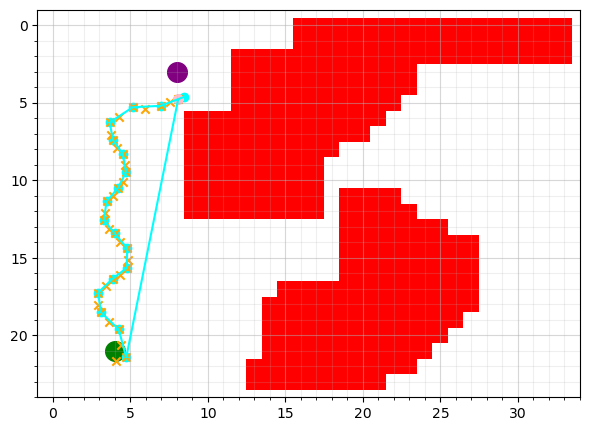

[[202.         119.          -1.97103698]
 [202.         119.          -1.97103698]
 [202.         119.          -1.97103698]
 [202.         119.          -1.97103698]
 [202.         119.          -1.97103698]
 [202.         119.          -1.97103698]
 [202.         119.          -1.97103698]
 [202.         119.          -1.97103698]
 [202.         119.          -1.97103698]
 [202.         119.          -1.97103698]
 [202.         119.          -1.97103698]
 [202.         119.          -1.97103698]
 [202.         119.          -1.97103698]
 [202.         119.          -1.97103698]
 [202.         119.          -1.97103698]
 [202.         119.          -1.97103698]
 [202.         119.          -1.97103698]
 [202.         119.          -1.97103698]
 [202.         119.          -1.97103698]
 [202.         119.          -1.97103698]
 [202.         119.          -1.97103698]
 [202.         119.          -1.97103698]
 [202.         119.          -1.97103698]
 [202.         119.          -1.97

In [31]:
# Displaying the map
fig_astar, ax = create_empty_plot(max_val_y)
ax.imshow(occupancy_grid, cmap=cmap)
#print(path_final)
#print(path_followed)
# Plot the best path found and the list of visited nodes
#ax.plot(path[1], path[0], marker="o", color = 'blue');
ax.scatter(start[1], start[0], marker="o", color = 'green', s=200);
ax.scatter(goal[1], goal[0], marker="o", color = 'purple', s=200);
x = path_followed[:, 0]/reduction_coeff
y = path_followed[:, 1]/reduction_coeff
x2 = path_apriori[:, 0]/reduction_coeff
y2 = path_apriori[:, 1]/reduction_coeff
x3 = path_camera[:, 0]/reduction_coeff
y3 = path_camera[:, 1]/reduction_coeff
ax.scatter(x, y, marker="o", color = 'cyan')
ax.scatter(x2, y2, marker="x", color = 'orange')
ax.scatter(x3, y3, marker="o", color = 'pink')
ax.plot(x, y, color = 'cyan')
plt.show()
print(path_camera)

# Conclusion

During this project, we have engineered and implemented various components, including vision, filtering, motion control, as well as global and local navigation. Our project is fully functional, and the Thymio is proficient in reaching its destination while adhering to the optimal path and circumventing obstacles through global navigation and local avoidance. We have successfully applied various techniques that we have learned over the semester in the *Basics of Mobile Robotics* course.

This project has been intriguing both technically and organizationally. The creation of a comprehensive project within a relatively short timeframe compelled us to make compromises. Nevertheless, the project operates efficiently across a wide array of tests.